## Notes
#### Soure
This notebook is based on:
- [LLC_analysis](https://github.com/dhruvbalwada/LLC_analysis)

#### Keypoints
- Try the Pangeo Could
- Processing LLC4320 surface variables on Cloud
- Calulate the vorticity
- Use `rolling` to smooth data
- Use `coarsen` to choose data
- Feel the difference speed between Cloud and ECCO

![](https://freight.cargo.site/t/original/i/60264f5e096dc58a3bffc938bdfbbb21c8cd9c347fd592c2489109b9e8b3a667/CCS-copy-2.jpg)
Antarctic Circumpolar Current

In [2]:
import dask
dask.config.set({"logging.distributed": "warning"})
from dask_gateway import GatewayCluster
from dask.distributed import Client
cluster = GatewayCluster()
cluster.scale(5) # worker number
client = Client(cluster)
cluster

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load some useful modules 
import numpy as np
import xarray as xr
import xrft
import intake
from xmitgcm import llcreader
from matplotlib import pyplot as plt

%matplotlib inline

In [5]:
cat_url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml"
cat = intake.open_catalog(cat_url)

In [6]:
cat

llc4320:
  args:
    path: https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


In [7]:
# Get variables from catalog
sst = cat.LLC4320_SST.to_dask()
sss = cat.LLC4320_SSS.to_dask()
ssh = cat.LLC4320_SSH.to_dask()
u = cat.LLC4320_SSU.to_dask()
v = cat.LLC4320_SSV.to_dask()

In [8]:
sst # There is no Lat/Lon.

,Array,Chunk
Bytes,7.97 TiB,71.19 MiB
Shape,"(9030, 13, 4320, 4320)","(1, 1, 4320, 4320)"
Count,117391 Tasks,117390 Chunks
Type,float32,numpy.ndarray


In [9]:
sss # Has Lat/Lon

<xarray.Dataset>
Dimensions:  (time: 9030, face: 13, j: 4320, i: 4320, i_g: 4320, j_g: 4320,
              k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89 90
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables:
    SSS      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(9030,), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [67]:
ds = xr.merge([ssh, sst, sss, u, v])
ds # Note that the coords grid is different (i_g,i_g)

,Array,Chunk
Bytes,7.97 TiB,71.19 MiB
Shape,"(9030, 13, 4320, 4320)","(1, 1, 4320, 4320)"
Count,117391 Tasks,117390 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.97 TiB,71.19 MiB
Shape,"(9030, 13, 4320, 4320)","(1, 1, 4320, 4320)"
Count,117391 Tasks,117390 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [68]:
ds = llcreader.llcmodel.faces_dataset_to_latlon(ds, metric_vector_pairs=[])
ds

,Array,Chunk
Bytes,7.36 TiB,71.19 MiB
Shape,"(9030, 12960, 17280)","(1, 4320, 4320)"
Count,659191 Tasks,108360 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.36 TiB,71.19 MiB
Shape,"(9030, 12960, 17280)","(1, 4320, 4320)"
Count,659191 Tasks,108360 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [69]:
coords = cat.LLC4320_grid.to_dask().reset_coords()
coords

<xarray.Dataset>
Dimensions:  (face: 13, j: 4320, i: 4320, k_p1: 2, j_g: 4320, i_g: 4320,
              time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k_p1     (k_p1) int64 0 1
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables: (12/30)
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    PHrefC   float32 ...
    PHrefF   (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    ...       ...
    k_l      int64 ...
    k_u      int64 ...
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [70]:
coords = llcreader.llcmodel.faces_dataset_to_latlon(coords)
coords

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, i_g: 17280, j: 12960, j_g: 12960, k_p1: 2,
              time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * k_p1     (k_p1) int64 0 1
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables: (12/30)
    CS       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    PHrefC   float32 15.4
    PHrefF   (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    ...       ...
    rAw      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>
    dyG      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>

In [71]:
ds

,Array,Chunk
Bytes,7.36 TiB,71.19 MiB
Shape,"(9030, 12960, 17280)","(1, 4320, 4320)"
Count,659191 Tasks,108360 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.36 TiB,71.19 MiB
Shape,"(9030, 12960, 17280)","(1, 4320, 4320)"
Count,659191 Tasks,108360 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [72]:
ds2 = xr.merge([ds, coords.dxC,coords.dyC,coords.rAz])

In [73]:
ds2=ds2.isel(time=0)

In [74]:
ds2.U

<xarray.DataArray 'U' (j: 12960, i_g: 17280)>
dask.array<getitem, shape=(12960, 17280), dtype=float32, chunksize=(4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
    time     datetime64[ns] 2011-09-13
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279

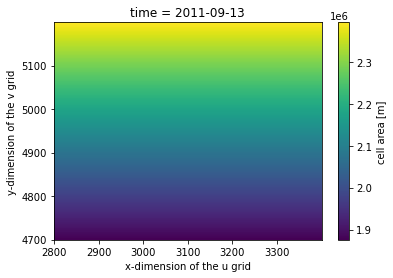

In [75]:
ds2.rAz.isel(i_g=slice(2800, 3400,1),j_g=slice(4700,5200,1)).plot()

In [76]:
ds2.dxC

<xarray.DataArray 'dxC' (j: 12960, i_g: 17280)>
dask.array<concatenate, shape=(12960, 17280), dtype=float32, chunksize=(4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
    time     datetime64[ns] 2011-09-13
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
Attributes:
    coordinate:     YC XG
    long_name:      cell x size
    standard_name:  cell_x_size_at_u_location
    units:          m

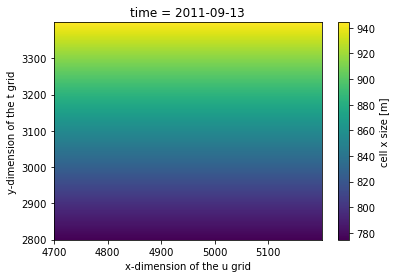

In [77]:
ds2.dxC.isel(j=slice(2800, 3400,1),i_g=slice(4700,5200,1)).plot()

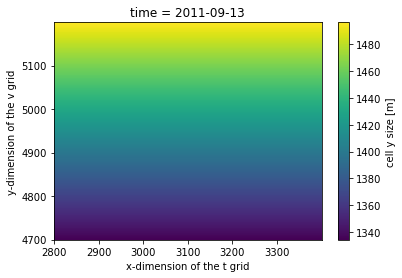

In [78]:
ds2.dyC.isel(i=slice(2800, 3400,1),j_g=slice(4700,5200,1)).plot()

In [79]:
import xgcm
grid = xgcm.Grid(ds, periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   k --> left
  * left     k_l --> center
  * outer    k_p1 --> center
  * right    k_u --> center

In [81]:
zeta = (-grid.diff(ds2.U * ds2.dxC, 'Y', boundary='fill') + grid.diff(ds2.V * ds2.dyC, 'X'))/ds2.rAz
zeta

<xarray.DataArray (j_g: 12960, i_g: 17280)>
dask.array<truediv, shape=(12960, 17280), dtype=float32, chunksize=(4319, 4320), chunktype=numpy.ndarray>
Coordinates:
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
    time     datetime64[ns] 2011-09-13

In [82]:
zeta = zeta.squeeze().rename('vorticity').reset_coords(drop=True)
zeta

<xarray.DataArray 'vorticity' (j_g: 12960, i_g: 17280)>
dask.array<truediv, shape=(12960, 17280), dtype=float32, chunksize=(4319, 4320), chunktype=numpy.ndarray>
Coordinates:
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959

In [83]:
%%time
zeta.load(); # sometimes it hangs up with no reason. DO not know why?

CPU times: user 24.9 s, sys: 13.7 s, total: 38.6 s
Wall time: 10.2 s


<xarray.DataArray 'vorticity' (j_g: 12960, i_g: 17280)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959

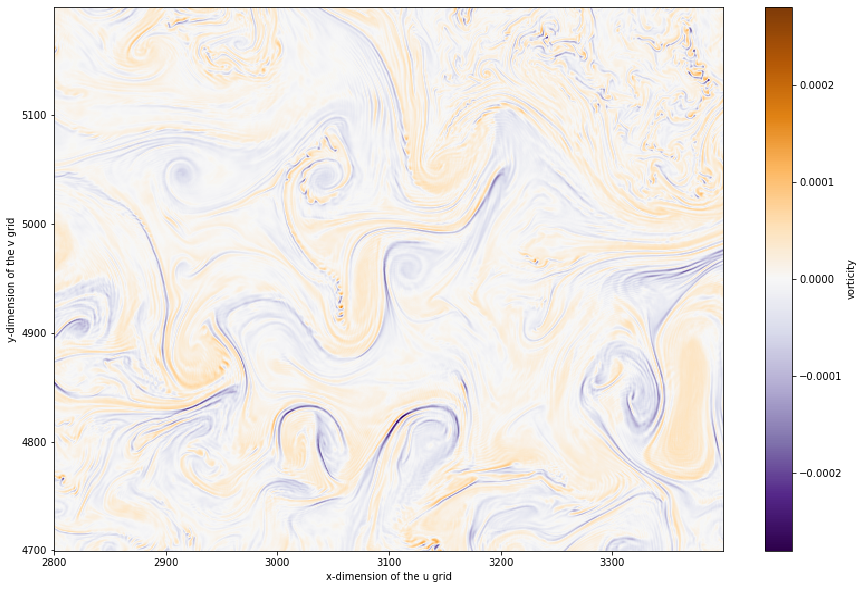

In [84]:
zeta.isel(i_g=slice(2800, 3400,1),j_g=slice(4700,5200,1)).where((zeta < 0.0003) & (zeta >-0.0003)).plot(aspect=1.5, size=10,cmap="PuOr_r")

In [18]:
# sel_sogos = np.logical_and(np.logical_and(coords.XC>28, coords.XC<40 ), 
#                            np.logical_and(coords.YC>-56, coords.YC<-48 ))

In [85]:
ds

,Array,Chunk
Bytes,7.36 TiB,71.19 MiB
Shape,"(9030, 12960, 17280)","(1, 4320, 4320)"
Count,659191 Tasks,108360 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.36 TiB,71.19 MiB
Shape,"(9030, 12960, 17280)","(1, 4320, 4320)"
Count,659191 Tasks,108360 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [88]:
# SST_sogos = ds.SST.where(sel_sogos, drop=True) # Do not use `where` to select data
SST_sogos = ds.SST.isel(i=slice(1824, 4703,1),j=slice(4040,6857,1),time=slice(70*24))

In [89]:
SST_sogos # 

<xarray.DataArray 'SST' (time: 1680, j: 2817, i: 2879)>
dask.array<getitem, shape=(1680, 2817, 2879), dtype=float32, chunksize=(1, 2537, 2496), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 1824 1825 1826 1827 1828 ... 4698 4699 4700 4701 4702
  * j        (j) int64 4040 4041 4042 4043 4044 ... 6852 6853 6854 6855 6856
  * time     (time) datetime64[ns] 2011-09-13 ... 2011-11-21T23:00:00

In [90]:
small_ex2=ds.SSS.isel(i=slice(3000, 3001,1),j=slice(4040,4041,1),time=slice(70*24))

In [91]:
small_ex2

<xarray.DataArray 'SSS' (time: 1680, j: 1, i: 1)>
dask.array<getitem, shape=(1680, 1, 1), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 3000
  * j        (j) int64 4040
  * time     (time) datetime64[ns] 2011-09-13 ... 2011-11-21T23:00:00

In [92]:
%%time
small_ex2.load() # 真正计算，提取数据。

CPU times: user 3min 31s, sys: 1min 39s, total: 5min 10s
Wall time: 1min 25s


<xarray.DataArray 'SSS' (time: 1680, j: 1, i: 1)>
array([[[33.897873]],

       [[33.903137]],

       [[33.90699 ]],

       ...,

       [[33.77316 ]],

       [[33.764473]],

       [[33.75458 ]]], dtype=float32)
Coordinates:
  * i        (i) int64 3000
  * j        (j) int64 4040
  * time     (time) datetime64[ns] 2011-09-13 ... 2011-11-21T23:00:00

CPU times: user 36.5 ms, sys: 3.91 ms, total: 40.4 ms
Wall time: 33.4 ms


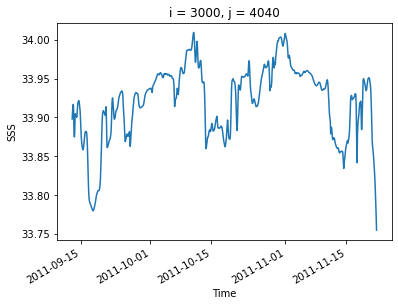

In [93]:
%%time
small_ex2.plot() 

In [94]:
# !pwd

In [95]:
small_ex2.to_netcdf('file4.nc')

In [98]:
# coarsen表示数据的抽希，返回的是core.rolling.DataArrayCoarsen。
# SST_sogos_av_monthly = SST_sogos.coarsen(
#         time=30*24, boundary='trim').mean().mean(['i','j'])
SST_sogos_av_monthly = SST_sogos.coarsen(
        time=1*24, boundary='trim').mean().mean(['i','j'])

In [99]:
SST_sogos_av_monthly

<xarray.DataArray 'SST' (time: 70)>
dask.array<mean_agg-aggregate, shape=(70,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13T11:30:00 ... 2011-11-21T11:30:00

In [34]:
# %%time
# SST_sogos_av_monthly.load()

In [100]:
%%time
# SST_sogos_av_monthly=SST_sogos_av_monthly0.mean(['i','j'])
SST_sogos_av_monthly.load(); # 真正的计算开始，5worker用时4min，20worker用时2min
# 有时候会计算失败，原因不明？

CPU times: user 20min 3s, sys: 8min 45s, total: 28min 49s
Wall time: 10min 59s


<xarray.DataArray 'SST' (time: 70)>
array([8.490019 , 8.507275 , 8.5245695, 8.500591 , 8.470575 , 8.452482 ,
       8.436697 , 8.4448395, 8.459476 , 8.469035 , 8.46558  , 8.467676 ,
       8.473587 , 8.474774 , 8.47743  , 8.480087 , 8.4997835, 8.516634 ,
       8.531205 , 8.546404 , 8.556111 , 8.569186 , 8.563742 , 8.550178 ,
       8.53976  , 8.571351 , 8.616174 , 8.638022 , 8.640634 , 8.661142 ,
       8.697713 , 8.720832 , 8.745032 , 8.77091  , 8.789505 , 8.818429 ,
       8.859488 , 8.875889 , 8.885404 , 8.921042 , 8.961579 , 9.000434 ,
       9.013904 , 9.033175 , 9.055473 , 9.073086 , 9.090539 , 9.092784 ,
       9.049409 , 8.995231 , 8.984089 , 8.998549 , 9.018412 , 9.048691 ,
       9.087881 , 9.123208 , 9.125091 , 9.1260605, 9.144069 , 9.194426 ,
       9.244144 , 9.274012 , 9.302055 , 9.3579   , 9.417475 , 9.43782  ,
       9.458621 , 9.4715605, 9.453495 , 9.41228  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13T11:30:00 ... 2011-11-21T11:30:00

In [101]:
SST_sogos_av_monthly.values


array([8.490019 , 8.507275 , 8.5245695, 8.500591 , 8.470575 , 8.452482 ,
       8.436697 , 8.4448395, 8.459476 , 8.469035 , 8.46558  , 8.467676 ,
       8.473587 , 8.474774 , 8.47743  , 8.480087 , 8.4997835, 8.516634 ,
       8.531205 , 8.546404 , 8.556111 , 8.569186 , 8.563742 , 8.550178 ,
       8.53976  , 8.571351 , 8.616174 , 8.638022 , 8.640634 , 8.661142 ,
       8.697713 , 8.720832 , 8.745032 , 8.77091  , 8.789505 , 8.818429 ,
       8.859488 , 8.875889 , 8.885404 , 8.921042 , 8.961579 , 9.000434 ,
       9.013904 , 9.033175 , 9.055473 , 9.073086 , 9.090539 , 9.092784 ,
       9.049409 , 8.995231 , 8.984089 , 8.998549 , 9.018412 , 9.048691 ,
       9.087881 , 9.123208 , 9.125091 , 9.1260605, 9.144069 , 9.194426 ,
       9.244144 , 9.274012 , 9.302055 , 9.3579   , 9.417475 , 9.43782  ,
       9.458621 , 9.4715605, 9.453495 , 9.41228  ], dtype=float32)

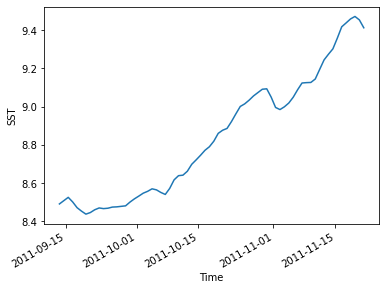

In [102]:
SST_sogos_av_monthly.plot()

In [31]:
SST_sogos = ds.SST.isel(i=slice(1824, 4703,1),j=slice(4040,6857,1),time=slice(70*24))

In [32]:
SST_sogos

<xarray.DataArray 'SST' (time: 1680, j: 2817, i: 2879)>
dask.array<getitem, shape=(1680, 2817, 2879), dtype=float32, chunksize=(1, 2537, 2496), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 1824 1825 1826 1827 1828 ... 4698 4699 4700 4701 4702
  * j        (j) int64 4040 4041 4042 4043 4044 ... 6852 6853 6854 6855 6856
  * time     (time) datetime64[ns] 2011-09-13 ... 2011-11-21T23:00:00

In [33]:
lwindow = 40 # do a rolling box avg over 40 grid points 
SST_sogos_ls = (SST_sogos.rolling(i=lwindow, center=True).mean()
                   ).rolling(j=lwindow, center=True).mean()

In [34]:
SST_sogos_ls

<xarray.DataArray 'SST' (time: 1680, j: 2817, i: 2879)>
dask.array<truediv, shape=(1680, 2817, 2879), dtype=float64, chunksize=(1, 2516, 2516), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 1824 1825 1826 1827 1828 ... 4698 4699 4700 4701 4702
  * j        (j) int64 4040 4041 4042 4043 4044 ... 6852 6853 6854 6855 6856
  * time     (time) datetime64[ns] 2011-09-13 ... 2011-11-21T23:00:00

In [35]:
SST_sogos_ss = SST_sogos - SST_sogos_ls

In [36]:
SST_sogos_ss

,Array,Chunk
Bytes,101.51 GiB,47.91 MiB
Shape,"(1680, 2817, 2879)","(1, 2516, 2496)"
Count,2130566 Tasks,26880 Chunks
Type,float64,numpy.ndarray


CPU times: user 24.8 s, sys: 2.42 s, total: 27.2 s
Wall time: 34.1 s


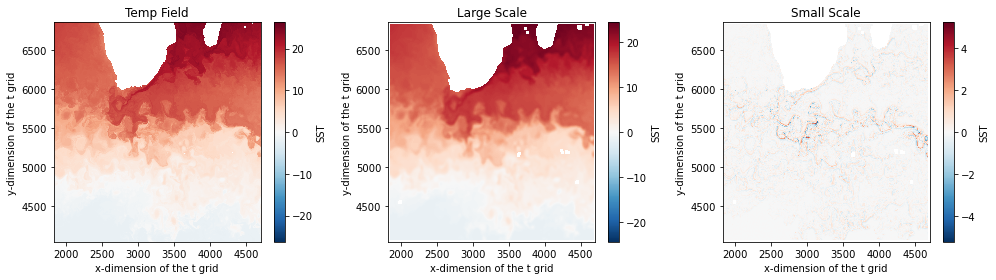

In [37]:
%%time
plt.figure(figsize=(14,4))
plt.subplot(131)
SST_sogos.isel(time=0).plot()
plt.title('Temp Field')

plt.subplot(132)
SST_sogos_ls.isel(time=0).plot()
plt.title('Large Scale')

plt.subplot(133)
SST_sogos_ss.isel(time=0).plot()
plt.title('Small Scale')
plt.tight_layout()

plt.savefig('method.png')

In [ ]:
# # Seasonal cycle of small scale variance
# SST_sogos_ss_monthly = SST_sogos_ss.isel(
#             time=slice(0,9030,15*24)).coarsen(
#             time=7*24, boundary='trim').var().var(['i','j'])

In [38]:
SST_sogos_ss

,Array,Chunk
Bytes,101.51 GiB,47.91 MiB
Shape,"(1680, 2817, 2879)","(1, 2516, 2496)"
Count,2130566 Tasks,26880 Chunks
Type,float64,numpy.ndarray


In [48]:
# SST_sogos_ss_monthly = SST_sogos_ss.isel(
#            time=slice(0,1680,2*24)).var(['i','j'])
SST_sogos_ss_monthly = SST_sogos_ss.isel(
           time=slice(0,1680,10*24)).var(['i','j']) # 2天一个值，

In [49]:
SST_sogos_ss_monthly

<xarray.DataArray 'SST' (time: 7)>
dask.array<moment_agg-aggregate, shape=(7,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 2011-09-23 ... 2011-11-12

In [46]:
# SST_sogos_ss_monthly.var(['i','j','time']) # variance？
# SST_sogos_ss_monthly.var(['i','j']) # variance？剩下时间信息，结果就是以时间为坐标

In [50]:
%%time
SST_sogos_ss_monthly.load();

CPU times: user 56.9 s, sys: 14.2 s, total: 1min 11s
Wall time: 21.9 s


<xarray.DataArray 'SST' (time: 7)>
array([0.11155471, 0.11432566, 0.12438255, 0.12515492, 0.11817131,
       0.11234713, 0.11014557])
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 2011-09-23 ... 2011-11-12

In [55]:
SST_sogos_ss_monthly.values # 这个数据表示异常信号

array([0.11155471, 0.11432566, 0.12438255, 0.12515492, 0.11817131,
       0.11234713, 0.11014557])

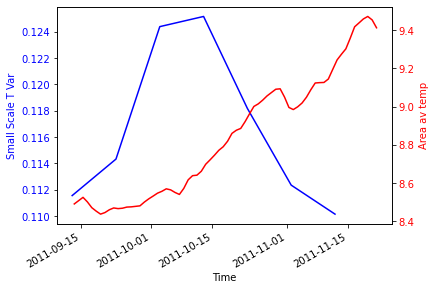

In [54]:
fig, ax1 = plt.subplots()
SST_sogos_ss_monthly.plot(ax=ax1,color='b')
ax1.set_ylabel('Small Scale T Var', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2= ax1.twinx()
SST_sogos_av_monthly.plot(ax=ax2, color='r');
ax2.set_ylabel('Area av temp',color='r')
ax2.tick_params(axis='y', labelcolor='r')

#plt.savefig('method2.png')